<a href="https://colab.research.google.com/github/Mc4minta/AIB5-PcapAttackClassifier/blob/main/BenignAttackLGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import pandas as pd
import numpy as np
import os

csv_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/GeneratedLabelledFlows/TrafficLabelling'

csv_files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',     # Benign, DDOS,
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', # Benign, Portscan
    'Monday-WorkingHours.pcap_ISCX.csv',                    # Benign
    'Tuesday-WorkingHours.pcap_ISCX.csv',                   # Benign, FTP, SSH
    'Wednesday-workingHours.pcap_ISCX.csv',                 # Benign, DOSs, Heartbleed

    #'Thursday-WorkingHours-Morning-WebAttacks-Fix.pcap_ISCX.csv' # Benign, Web attacks (Fixed)

    # 'Friday-WorkingHours-Morning.pcap_ISCX.csv',          # Benign, Bot
    # 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv' # Benign, Web attacks
    # 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', # Benign, Infiltration
]

dfs = []

for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    try:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip().str.replace(' ', '_')  # Clean column names

        if 'Label' not in df.columns:
            print(f"Label column missing in: {file}")
            continue

        # Drop 65% of BENIGN samples
        benign_df = df[df['Label'] == 'BENIGN']
        non_benign_df = df[df['Label'] != 'BENIGN']

        # Drop 65% of BENIGN samples randomly
        dropped_benign = benign_df.sample(frac=0.35, random_state=42)

        # Concatenate back with attack samples
        reduced_df = pd.concat([dropped_benign, non_benign_df], ignore_index=True)

        dfs.append(reduced_df)
        print(f"Loaded and reduced BENIGN in: {file}")

    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error with {file}: {e}")

# Combine all files
df = pd.concat(dfs, ignore_index=True)

# Drop unneeded columns
columns_to_drop = [
    'Flow_ID', 'Source_IP', 'Destination_IP', 'Protocol', 'Timestamp', 'Fwd_Header_Length.1',
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Clean infinite or missing values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

df.head()

Loaded and reduced BENIGN in: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loaded and reduced BENIGN in: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loaded and reduced BENIGN in: Monday-WorkingHours.pcap_ISCX.csv
Loaded and reduced BENIGN in: Tuesday-WorkingHours.pcap_ISCX.csv
Loaded and reduced BENIGN in: Wednesday-workingHours.pcap_ISCX.csv


,Source_Port,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,40474,7182757,1,5,6.0,30.0,6.0,6.0,6.0,...,20,45201.000,0.000,45201.0,45201.0,7137556.0,0.00,7137556.0,7137556.0,BENIGN
1,80,28907,938509,1,5,6.0,30.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
2,0,0,119995732,123,0,0.0,0.0,0.0,0.0,0.0,...,0,3753432.167,5183854.063,13200000.0,1.0,13100000.0,6507819.26,26300000.0,6484077.0,BENIGN
3,58168,443,142954,10,6,553.0,3949.0,196.0,0.0,55.3,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
4,80,17541,2548725,1,6,6.0,36.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN


In [29]:
columns_mapping = {
    'Src_Port': 'Source_Port',
    'Dst_Port': 'Destination_Port',
    'Flow_Duration': 'Flow_Duration',
    'Tot_Fwd_Pkts': 'Total_Fwd_Packets',
    'Tot_Bwd_Pkts': 'Total_Backward_Packets',
    'TotLen_Fwd_Pkts': 'Total_Length_of_Fwd_Packets',
    'TotLen_Bwd_Pkts': 'Total_Length_of_Bwd_Packets',
    'Fwd_Pkt_Len_Max': 'Fwd_Packet_Length_Max',
    'Fwd_Pkt_Len_Min': 'Fwd_Packet_Length_Min',
    'Fwd_Pkt_Len_Mean': 'Fwd_Packet_Length_Mean',
    'Fwd_Pkt_Len_Std': 'Fwd_Packet_Length_Std',
    'Bwd_Pkt_Len_Max': 'Bwd_Packet_Length_Max',
    'Bwd_Pkt_Len_Min': 'Bwd_Packet_Length_Min',
    'Bwd_Pkt_Len_Mean': 'Bwd_Packet_Length_Mean',
    'Bwd_Pkt_Len_Std': 'Bwd_Packet_Length_Std',
    'Flow_Byts/s': 'Flow_Bytes/s',
    'Flow_Pkts/s': 'Flow_Packets/s',
    'Flow_IAT_Mean': 'Flow_IAT_Mean',
    'Flow_IAT_Std': 'Flow_IAT_Std',
    'Flow_IAT_Max': 'Flow_IAT_Max',
    'Flow_IAT_Min': 'Flow_IAT_Min',
    'Fwd_IAT_Tot': 'Fwd_IAT_Total',
    'Fwd_IAT_Mean': 'Fwd_IAT_Mean',
    'Fwd_IAT_Std': 'Fwd_IAT_Std',
    'Fwd_IAT_Max': 'Fwd_IAT_Max',
    'Fwd_IAT_Min': 'Fwd_IAT_Min',
    'Bwd_IAT_Tot': 'Bwd_IAT_Total',
    'Bwd_IAT_Mean': 'Bwd_IAT_Mean',
    'Bwd_IAT_Std': 'Bwd_IAT_Std',
    'Bwd_IAT_Max': 'Bwd_IAT_Max',
    'Bwd_IAT_Min': 'Bwd_IAT_Min',
    'Fwd_PSH_Flags': 'Fwd_PSH_Flags',
    'Bwd_PSH_Flags': 'Bwd_PSH_Flags',
    'Fwd_URG_Flags': 'Fwd_URG_Flags',
    'Bwd_URG_Flags': 'Bwd_URG_Flags',
    'Fwd_Header_Len': 'Fwd_Header_Length',
    'Bwd_Header_Len': 'Bwd_Header_Length',
    'Fwd_Pkts/s': 'Fwd_Packets/s',
    'Bwd_Pkts/s': 'Bwd_Packets/s',
    'Pkt_Len_Min': 'Min_Packet_Length',
    'Pkt_Len_Max': 'Max_Packet_Length',
    'Pkt_Len_Mean': 'Packet_Length_Mean',
    'Pkt_Len_Std': 'Packet_Length_Std',
    'Pkt_Len_Var': 'Packet_Length_Variance',
    'FIN_Flag_Cnt': 'FIN_Flag_Count',
    'SYN_Flag_Cnt': 'SYN_Flag_Count',
    'RST_Flag_Cnt': 'RST_Flag_Count',
    'PSH_Flag_Cnt': 'PSH_Flag_Count',
    'ACK_Flag_Cnt': 'ACK_Flag_Count',
    'URG_Flag_Cnt': 'URG_Flag_Count',
    'CWE_Flag_Count': 'CWE_Flag_Count',
    'ECE_Flag_Cnt': 'ECE_Flag_Count',
    'Down/Up_Ratio': 'Down/Up_Ratio',
    'Pkt_Size_Avg': 'Average_Packet_Size',
    'Fwd_Seg_Size_Avg': 'Avg_Fwd_Segment_Size',
    'Bwd_Seg_Size_Avg': 'Avg_Bwd_Segment_Size',
    'Fwd_Byts/b_Avg': 'Fwd_Byts/b_Avg',
    'Fwd_Pkts/b_Avg': 'Fwd_Pkts/b_Avg',
    'Fwd_Blk_Rate_Avg': 'Fwd_Blk_Rate_Avg',
    'Bwd_Byts/b_Avg': 'Bwd_Byts/b_Avg',
    'Bwd_Pkts/b_Avg': 'Bwd_Pkts/b_Avg',
    'Bwd_Blk_Rate_Avg': 'Bwd_Blk_Rate_Avg',
    'Subflow_Fwd_Pkts': 'Subflow_Fwd_Pkts',
    'Subflow_Fwd_Byts': 'Subflow_Fwd_Byts',
    'Subflow_Bwd_Pkts': 'Subflow_Bwd_Pkts',
    'Subflow_Bwd_Byts': 'Subflow_Bwd_Byts',
    'Init_Fwd_Win_Byts': 'Init_Fwd_Win_Byts',
    'Init_Bwd_Win_Byts': 'Init_Bwd_Win_Byts',
    'Fwd_Act_Data_Pkts': 'act_data_pkt_fwd',
    'Fwd_Seg_Size_Min': 'Fwd_Seg_Size_Min',
    'Active_Mean': 'Active_Mean',
    'Active_Std': 'Active_Std',
    'Active_Max': 'Active_Max',
    'Active_Min': 'Active_Min',
    'Idle_Mean': 'Idle_Mean',
    'Idle_Std': 'Idle_Std',
    'Idle_Max': 'Idle_Max',
    'Idle_Min': 'Idle_Min'
}


df = df.rename(columns=columns_mapping)
df = df.dropna()
df.head()

,Source_Port,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,40474,7182757,1,5,6.0,30.0,6.0,6.0,6.0,...,20,45201.000,0.000,45201.0,45201.0,7137556.0,0.00,7137556.0,7137556.0,BENIGN
1,80,28907,938509,1,5,6.0,30.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
2,0,0,119995732,123,0,0.0,0.0,0.0,0.0,0.0,...,0,3753432.167,5183854.063,13200000.0,1.0,13100000.0,6507819.26,26300000.0,6484077.0,BENIGN
3,58168,443,142954,10,6,553.0,3949.0,196.0,0.0,55.3,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
4,80,17541,2548725,1,6,6.0,36.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN


In [30]:
# Remove unused attacks rows
values_to_remove = ['Bot', 'Heartbleed']
df = df[~df['Label'].isin(values_to_remove)]
df = df.reset_index(drop=True)
df['Label'].value_counts()

,count
Label,
BENIGN,569110
DoS Hulk,230124
PortScan,158804
DDoS,128025
DoS GoldenEye,10293
FTP-Patator,7935
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499


In [31]:
# Groupped DOS Labels and rename FTP and SSH to be bruteforce
label_mapping = {
    'BENIGN': 'Benign',
    'DoS Hulk': 'Attack',
    'DDoS': 'Attack',
    'DoS GoldenEye': 'Attack',
    'DoS slowloris': 'Attack',
    'DoS Slowhttptest': 'Attack',
    'PortScan' : 'Attack',
    'FTP-Patator': 'Attack',
    'SSH-Patator': 'Attack',
}

# Apply the label mapping to the 'Label' column
df['Label'] = df['Label'].map(label_mapping)
df['Label'].value_counts()

,count
Label,
Benign,569110
Attack,552373


In [32]:
df = df[~((df['Label'] == 'Benign') & df.duplicated())]
df['Label'].value_counts()

,count
Label,
Benign,567789
Attack,552373


In [33]:
# prompt: compare the count of benigh label row and all other label row combine

benign_count = len(df[df['Label'] == 'Benign'])
other_labels_count = len(df[df['Label'] != 'Benign'])

print(f"Benign: {benign_count}")
print(f"Attack: {other_labels_count}")

Benign: 567789
Attack: 552373


In [34]:
import pandas as pd
from pandas.api.types import CategoricalDtype

# Sample mapping function for ports
def map_port(port):
    if port == 21:
        return 'FTP'
    elif port == 22:
        return 'SSH'
    elif port == 53:
        return 'DNS'
    elif port == 80:
        return 'HTTP'
    elif port == 443:
        return 'HTTPS'
    else:
        return 'Other'

# Apply port mapping
df['Destination_Port'] = df['Destination_Port'].apply(map_port)
df['Source_Port'] = df['Source_Port'].apply(map_port)

# Define port categories
port_categories = ['FTP', 'SSH', 'DNS', 'HTTP', 'HTTPS', 'Other']
port_cat_type = CategoricalDtype(categories=port_categories, ordered=False)

# Convert both columns to categorical
df['Destination_Port'] = df['Destination_Port'].astype(port_cat_type)
df['Source_Port'] = df['Source_Port'].astype(port_cat_type)


In [35]:
df.head()

,Source_Port,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,HTTP,Other,7182757,1,5,6.0,30.0,6.0,6.0,6.0,...,20,45201.000,0.000,45201.0,45201.0,7137556.0,0.00,7137556.0,7137556.0,Benign
1,HTTP,Other,938509,1,5,6.0,30.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,Benign
2,Other,Other,119995732,123,0,0.0,0.0,0.0,0.0,0.0,...,0,3753432.167,5183854.063,13200000.0,1.0,13100000.0,6507819.26,26300000.0,6484077.0,Benign
3,Other,HTTPS,142954,10,6,553.0,3949.0,196.0,0.0,55.3,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,Benign
4,HTTP,Other,2548725,1,6,6.0,36.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,Benign


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120162 entries, 0 to 1121482
Data columns (total 79 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   Source_Port                  1120162 non-null  category
 1   Destination_Port             1120162 non-null  category
 2   Flow_Duration                1120162 non-null  int64   
 3   Total_Fwd_Packets            1120162 non-null  int64   
 4   Total_Backward_Packets       1120162 non-null  int64   
 5   Total_Length_of_Fwd_Packets  1120162 non-null  float64 
 6   Total_Length_of_Bwd_Packets  1120162 non-null  float64 
 7   Fwd_Packet_Length_Max        1120162 non-null  float64 
 8   Fwd_Packet_Length_Min        1120162 non-null  float64 
 9   Fwd_Packet_Length_Mean       1120162 non-null  float64 
 10  Fwd_Packet_Length_Std        1120162 non-null  float64 
 11  Bwd_Packet_Length_Max        1120162 non-null  float64 
 12  Bwd_Packet_Length_Min        1120

# LIGHTGBM

In [37]:
! pip install lightgbm

In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Binary label: 0 = Benign, 1 = Attack
X = df.drop('Label', axis=1)
y = df['Label'].apply(lambda x: 1 if x != 'Benign' else 0)

# Identify and convert categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    X[col] = X[col].astype('category')

# Stratified train/test split to ensure both classes are represented
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train LightGBM model
model = lgb.LGBMClassifier()

In [40]:
model.fit(X_train, y_train, categorical_feature=cat_cols.tolist())

[LightGBM] [Info] Number of positive: 441898, number of negative: 454231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.474748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13944
[LightGBM] [Info] Number of data points in the train set: 896129, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493119 -> initscore=-0.027527
[LightGBM] [Info] Start training from score -0.027527


LGBMClassifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113558
           1       1.00      1.00      1.00    110475

    accuracy                           1.00    224033
   macro avg       1.00      1.00      1.00    224033
weighted avg       1.00      1.00      1.00    224033



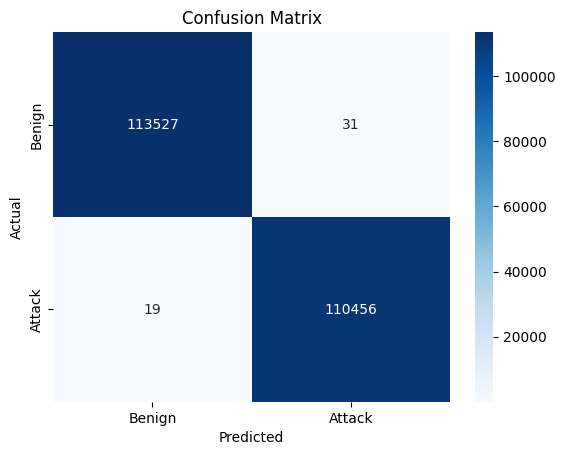

In [41]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation: classification report
print(classification_report(y_test, y_pred))

# Evaluation: confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

                        Feature  Importance
66       Init_Win_bytes_forward         427
67      Init_Win_bytes_backward         295
1              Destination_Port         173
20                 Flow_IAT_Min         143
35            Fwd_Header_Length         135
25                  Fwd_IAT_Min         122
15                 Flow_Bytes/s          97
0                   Source_Port          82
38                Bwd_Packets/s          71
41           Packet_Length_Mean          66
69         min_seg_size_forward          66
7         Fwd_Packet_Length_Max          65
14        Bwd_Packet_Length_Std          65
4        Total_Backward_Packets          64
22                 Fwd_IAT_Mean          61
13       Bwd_Packet_Length_Mean          58
2                 Flow_Duration          56
6   Total_Length_of_Bwd_Packets          55
21                Fwd_IAT_Total          52
47               PSH_Flag_Count          51


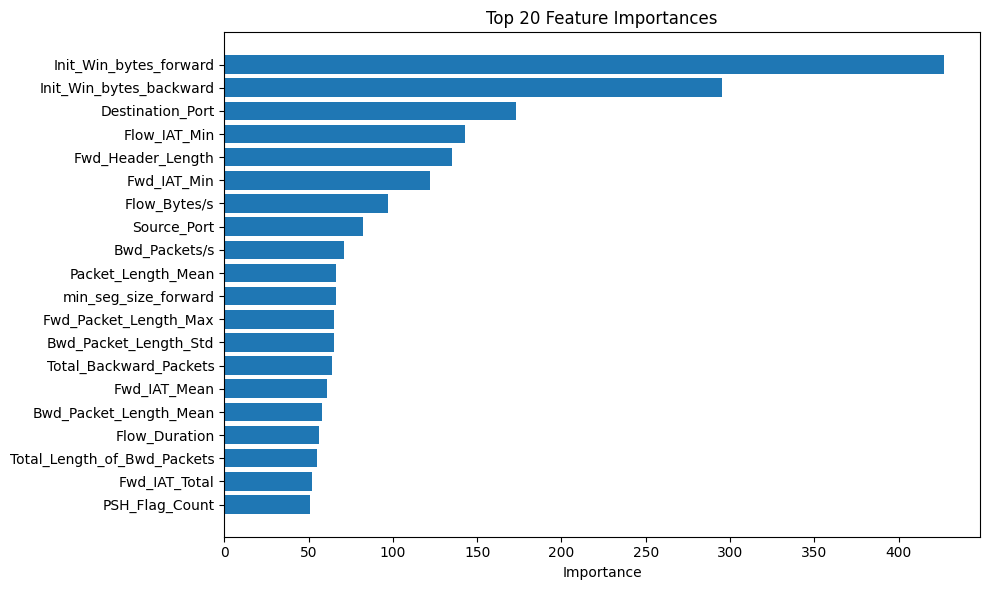

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances and corresponding feature names
importances = model.feature_importances_
feature_names = X_train.columns

# Combine into a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top N important features
print(feature_importance_df.head(20))

# Optional: plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20][::-1], feature_importance_df['Importance'][:20][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [42]:
import joblib

# Optional: Save the model using joblib
joblib.dump(model, '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/BenignAttackLGBM.pkl')

['/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/BenignAttackLGBM.pkl']